In [ ]:
!pip install gdown

In [ ]:
# Chuẩn bị dữ liệu
!gdown 10Gj0FXRZd0ZTcPavPiZCsvGnPV1oSuhN

Downloading...
From (original): https://drive.google.com/uc?id=10Gj0FXRZd0ZTcPavPiZCsvGnPV1oSuhN
From (redirected): https://drive.google.com/uc?id=10Gj0FXRZd0ZTcPavPiZCsvGnPV1oSuhN&confirm=t&uuid=c35d397f-eb1c-473c-bd78-5309e5a2cea8
To: /content/archive.zip
100% 8.77G/8.77G [02:33<00:00, 57.2MB/s]


In [ ]:
# Giải nén file dữ liệu
!unzip archive.zip

In [ ]:
# Cài cắm thư viện
!pip -q install sentence-transformers
!pip -q install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.1 MB/s eta 0:00:00


In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


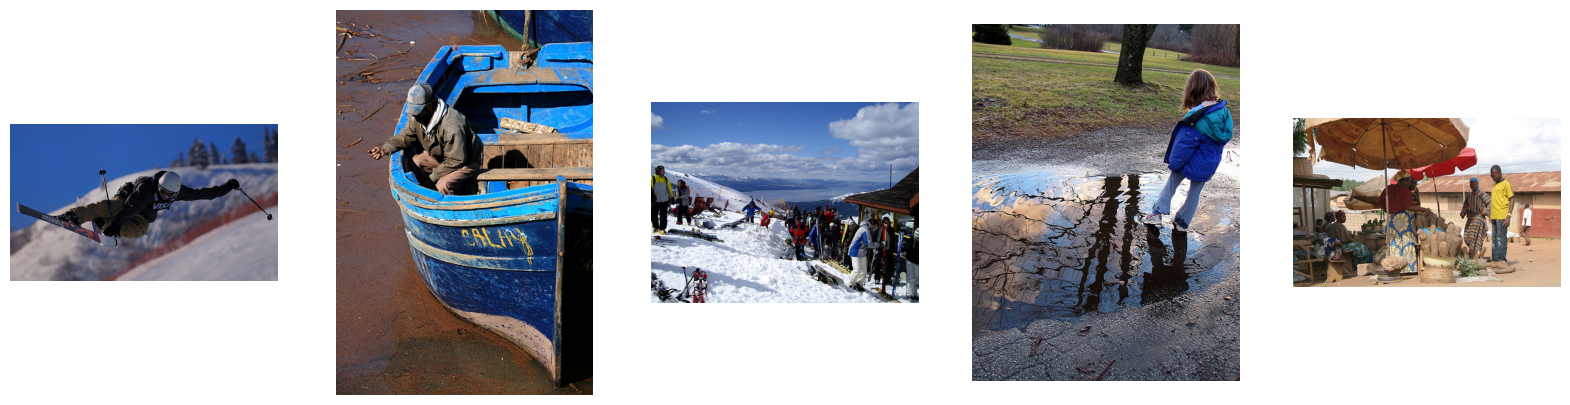

In [ ]:
# Show thử 1 vài hình ảnh trong bộ dữ liệu
image_folder = "/content/flickr30k_images/flickr30k_images"

# Lấy danh sách file trong thư mục hình ảnh

image_files = glob(os.path.join(image_folder, "*.jpg"))

# Chọn ngẫu nhiên 5 file hình ảnh
selected_files = random.sample(image_files, 5)

plt.figure(figsize=(20, 5))

for i, file in enumerate(selected_files):
    image = Image.open(file)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()




In [ ]:
# Tạo embbeding cho 30K ảnh bằng model
model = SentenceTransformer('clip-ViT-B-32')
image_path = "/content/flickr30k_images/flickr30k_images"

image_files = glob (os.path.join(image_path, "*.jpg"))
chunk_size = 256

embeddings = []

def process_chunk(chunk):
  images = []
  for image_file in chunk:
    images.append(Image.open(image_file))

  chunk_embeddings = model.encode(images)
  return chunk_embeddings

# for image_file in image_files:
#   image = Image.open(image_file)
#   image_embedding = model.encode(image)
#   embeddings.append(image_embedding)

for i in range(0, len(image_files), chunk_size):
    print(i)
    chunk = image_files[i:i + chunk_size]
    embeddings.extend(process_chunk(chunk))

In [ ]:
# Dựng lên vectorDB với FAISS
dimension = len(embeddings[0])
index = faiss.IndexFlatIP(dimension)
index = faiss.IndexIDMap(index)

vectors = np.array(embeddings).astype('float32')
index.add_with_ids(vectors, np.array(range(len(embeddings))))

# Save index vào file
faiss.write_index(index, "index.faiss")

# Ghi các tên ảnh vào tệp tin để load khi cần
with open("image_files.txt", "w") as f:
    for image_file in image_files:
        f.write(image_file + "\n")


In [ ]:
def search_image(query, model, index, image_files, top_k=5):
  # Query có thể là ảnh hoặc text

  if query.endswith(".jpg"):
    query = Image.open(query)

  query_embedding = model.encode(query)
  query_embedding = query_embedding.astype("float32").reshape(1, -1)

  distances, indices = index.search(query_embedding, top_k)

  retrieved_image_files = [image_files[i] for i in indices[0]]
  return query, retrieved_image_files


In [ ]:
# Visualize retrieved_image_files
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

In [ ]:
# Tìm kiếm từ text
query = "a yellow ballon"#"a red motorbike and a green field"
query, retrieved_image_files = search_image(query, model, index, image_files)

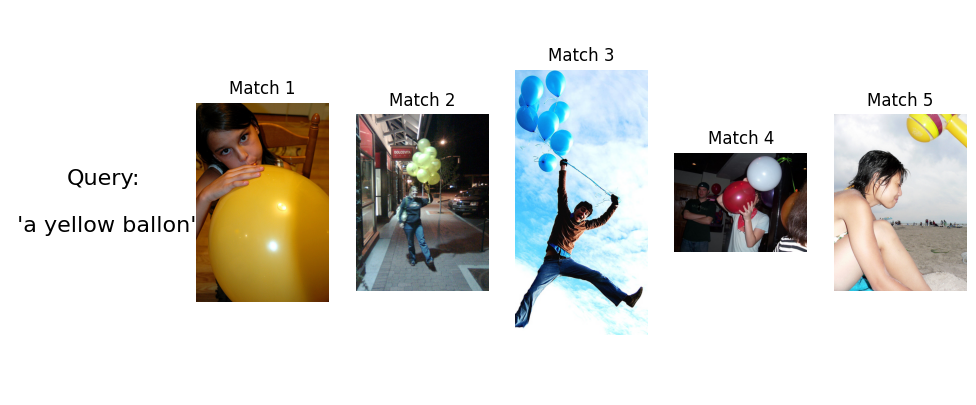

In [ ]:
visualize_results(query, retrieved_image_files)

In [ ]:
print(retrieved_image_files)

['/content/flickr30k_images/flickr30k_images/477141784.jpg', '/content/flickr30k_images/flickr30k_images/483286214.jpg', '/content/flickr30k_images/flickr30k_images/3569416047.jpg', '/content/flickr30k_images/flickr30k_images/2811001948.jpg', '/content/flickr30k_images/flickr30k_images/4474053436.jpg']
